In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans,DBSCAN

In [2]:
data= pd.read_excel('https://github.com/rwepa/DataDemo/blob/master/OnlineRetail.xlsx?raw=true')

In [3]:
display(data.head(2))
print(data.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(541909, 8)


In [4]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data= data[pd.notnull(data['CustomerID'])]

In [6]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

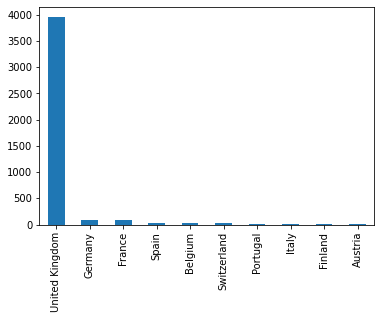

In [7]:
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [8]:
#majority of uk, so let's take only uk rows
uk_data=data[data.Country=='United Kingdom']

In [9]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
#negative quantity? impossible! let's remove them...
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


RFM analysis:
*  Recency: count the number of days between present date and the last date of purchase for customer
*  Frequency: count the number of order by each customer
*  MonetaryValue: count the total amount spent 

In [11]:
#we remove columns we don't need: Description,Country
#we prepare the columns also
uk_data=uk_data[['CustomerID','InvoiceNo','Quantity','InvoiceDate','UnitPrice']]
uk_data['TotalPrice'] = uk_data.Quantity * uk_data.UnitPrice
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])
uk_data.head(2)

,CustomerID,InvoiceNo,Quantity,InvoiceDate,UnitPrice,TotalPrice
0,17850.0,536365,6,2010-12-01 08:26:00,2.55,15.30
1,17850.0,536365,6,2010-12-01 08:26:00,3.39,20.34


In [12]:
PRESENT = dt.datetime(2011,12,10)
rfm= uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [13]:
rfm

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


In [14]:
rfm.columns=['recency','frequency','monetary']

In [15]:
rfm

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


## RFM Quantiles
*  Customers with low recency and high frequency and monetary are the top customers
*  use of qcut()

In [16]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [17]:
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2
...,...,...,...,...,...,...
18280.0,277,10,180.60,4,4,4
18281.0,180,7,80.82,4,4,4
18282.0,7,12,178.05,1,4,4


In [18]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+rfm.f_quartile.astype(str)+rfm.m_quartile.astype(str)
# Filter out Top/Best cusotmers
rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
18102.0,0,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
17511.0,2,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111
